<a href="https://colab.research.google.com/github/Al95200/machine-translation/blob/master/traducteur_anglais_francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all needed modules

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


# Loading dataset 

In [ ]:
with open("small_vocab_fr.txt") as f1, open("small_vocab_en.txt") as f2:
       line_file1 = f1.readlines()
       line_file2 = f2.readlines()
       print(len(line_file1), len(line_file2))

137860 137860


In [ ]:
temp = []
fr_eng = []
for fr, en in zip(line_file1, line_file2):
    temp.append(en)
    temp.append(fr)
    fr_eng.append(temp)
    temp = []

In [ ]:
fr_eng = array(fr_eng)

If you don't want to use all the rows to feed the neural network, uncomment next code chunk

In [ ]:
# fr_eng = fr_eng[:50000,:]

## Preprocessing

In this section, we prepare our data to fit the neural network. We do all needed preprocessing steps (removing punctuation, lowercase all sentences, build tokenizer)


In [ ]:
fr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,0]]
fr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,1]]


In [ ]:
for i in range(len(fr_eng)):
    fr_eng[i,0] = fr_eng[i,0].lower()
    fr_eng[i,1] = fr_eng[i,1].lower()


In [ ]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [ ]:
eng_tokenizer = tokenization(fr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 20
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 200


In [ ]:
fr_tokenizer = tokenization(fr_eng[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 20
print('French Vocabulary Size: %d' % fr_vocab_size)

French Vocabulary Size: 345


In [ ]:
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

# Finally we build our model

## We convert our word sequence as one hot encoded vector sequence for the neural network

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(fr_eng, test_size=0.2, random_state = 12)

In [ ]:
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

## Building the Neural Machine Translation model


In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.15_07_2020'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 88230 samples, validate on 22058 samples
Epoch 1/30
88230/88230 [==============================] - 22s 250us/step - loss: 2.0961 - val_loss: 1.3472

Epoch 00001: val_loss improved from inf to 1.34716, saving model to model.h1.15_07_2020
Epoch 2/30
88230/88230 [==============================] - 20s 224us/step - loss: 1.1178 - val_loss: 0.7583

Epoch 00002: val_loss improved from 1.34716 to 0.75829, saving model to model.h1.15_07_2020
Epoch 3/30
88230/88230 [==============================] - 20s 223us/step - loss: 0.7429 - val_loss: 0.5764

Epoch 00003: val_loss improved from 0.75829 to 0.57641, saving model to model.h1.15_07_2020
Epoch 4/30
88230/88230 [==============================] - 20s 224us/step - loss: 0.5793 - val_loss: 0.4842

Epoch 00004: val_loss improved from 0.57641 to 0.48424, saving model to model.h1.15_07_2020
Epoch 5/30
88230/88230 [==============================] - 20s 222us/step - loss: 0.4565 - val_loss: 0.3603

Epoch 00005: val_loss improved from 0.48424 to

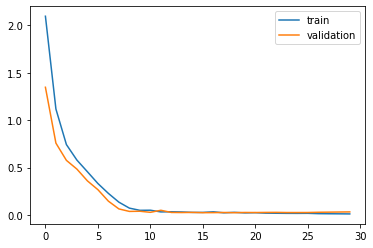

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
model = load_model('model.h1.15_07_2020')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
preds

array([[ 29,  11,  13, ...,   0,   0,   0],
       [ 24,   1,  10, ...,   0,   0,   0],
       [  5,  86,   1, ...,   0,   0,   0],
       ...,
       [151, 145,  81, ...,   0,   0,   0],
       [ 19,   1,  66, ...,   0,   0,   0],
       [  5,  85,   1, ...,   0,   0,   0]])

Here, we decode our one hot vector sequence to print predicted translated word sequence

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'predicted' : preds_text, 'actual' : test[:,0]})

## Display some of the predicted and actual translation




In [ ]:
pred_df.sample(50)

,predicted,actual
15880,california is never busy during fall and it is usually nice in may,california is never busy during fall and it is usually pleasant in may \n
17972,the orange is my most loved fruit but the grape is your most loved,the orange is my most loved fruit but the grape is your most loved \n
24585,he likes peaches grapefruit and strawberries,he likes peaches grapefruit and strawberries \n
5729,my favorite fruit is the pear but her favorite is the lemon,my favorite fruit is the pear but her favorite is the lemon \n
12862,the grape is your least favorite fruit but the lemon is my least favorite,the grape is your least favorite fruit but the lemon is my least favorite \n
12664,she was driving that old black car,she was driving that old black automobile \n
23511,india is usually beautiful during may but it is never quiet in september,india is usually beautiful during may but it is never quiet in september \n
18470,our least favorite fruit is the orange but their least favorite is the apple,our least favorite fruit is the orange but their least favorite is the apple \n
8999,paris is usually rainy during winter but it is usually busy in summer,paris is usually rainy during winter but it is usually busy in summer \n
4230,paris is sometimes relaxing during summer but it is rainy in march,paris is sometimes relaxing during summer but it is rainy in march \n
